In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

# Error vs. number of basis functions

Given a good set of basis functions, it's actually quite easy to fit the data well -- even exactly at some point. But this isn't necessarily what we want. Below we'll explore this through the following example

Text(0, 0.5, 'y')

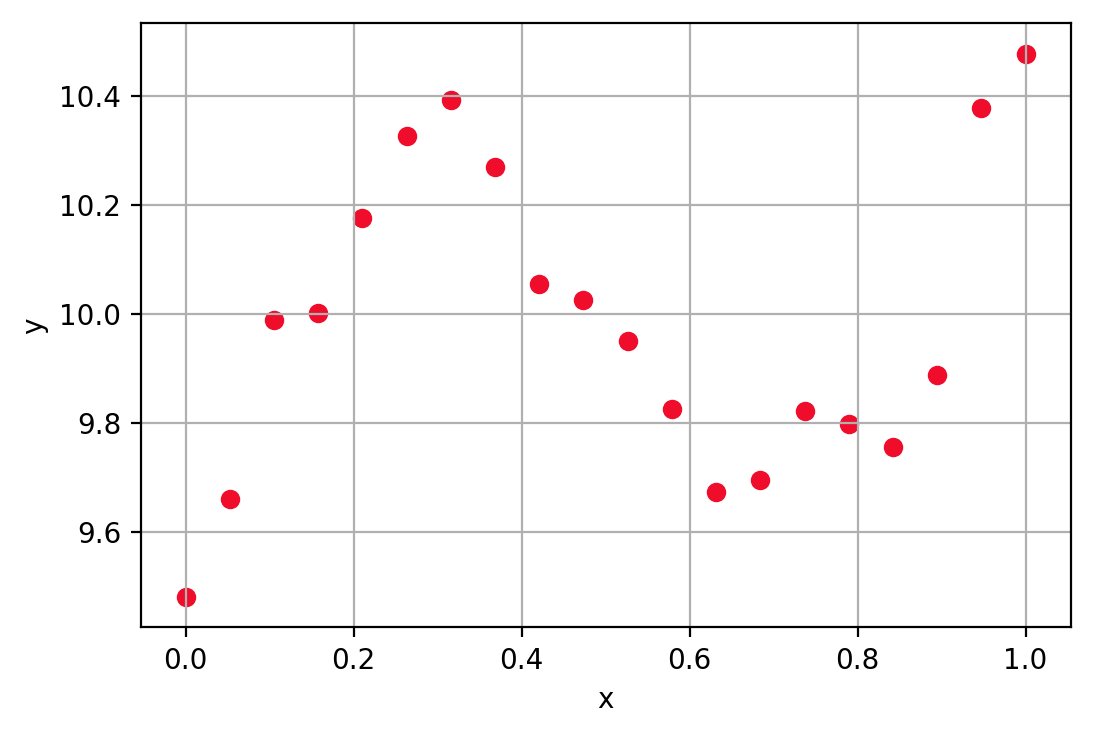

In [5]:
# Load the data
data = np.loadtxt('data/lec_17_example1.txt')
x_data = data[:,0]
y_data = data[:,1]

# Plot the data
plt.figure()
plt.grid()
plt.scatter(x_data, y_data)
plt.xlabel('x')
plt.ylabel('y')

We'll try linear least-squares regression using the monomial basis, resulting in the truncated power series:

$$ y = \theta_0 + \theta_1 x + \theta_2 x^2 + ... + \theta_n x^n, $$

We'll define a function to do this for any given $n$, so we don't have to re-write the code. In the function, we
have to define the design matrix given the monomial basis:

$$ \Phi = \begin{pmatrix} 1 & x_1 & x_1^2 & \cdots & x_1^n \\
1 & x_2 & x_2^2 & \cdots & x_2^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_m & x_m^2 & \cdots & x_m^n
\end{pmatrix}.$$

This design matrix has a name, the **Vandermonde Matrix**, which you can read about here:

https://en.wikipedia.org/wiki/Vandermonde_matrix

We can use the special `numpy` function `np.vander` to form this matrix for our given data.

In [7]:
# Fits a polynomial to the data using the monomial basis and linear least squares to find the coefficients 
def fit_poly(x, y, x_predict, n):
    
    # ---- TRAINING ----
    # Form the design matrix.
    Phi = np.vander(x, (n+1), increasing = True)
    
    # Get least squares solution
    theta_ls = np.linalg.lstsq(Phi, y, rcond = None)[0]
    
    
    # ---- PREDICTING ----
    # predict the function at the points in x_predict
    Phi_predict = np.vander(x_predict, (n+1), increasing = True)
    y_predict = Phi_predict @ theta_ls
    
    return y_predict

We'll try to fit the best $n = 1$ polynomial, i.e. a line.

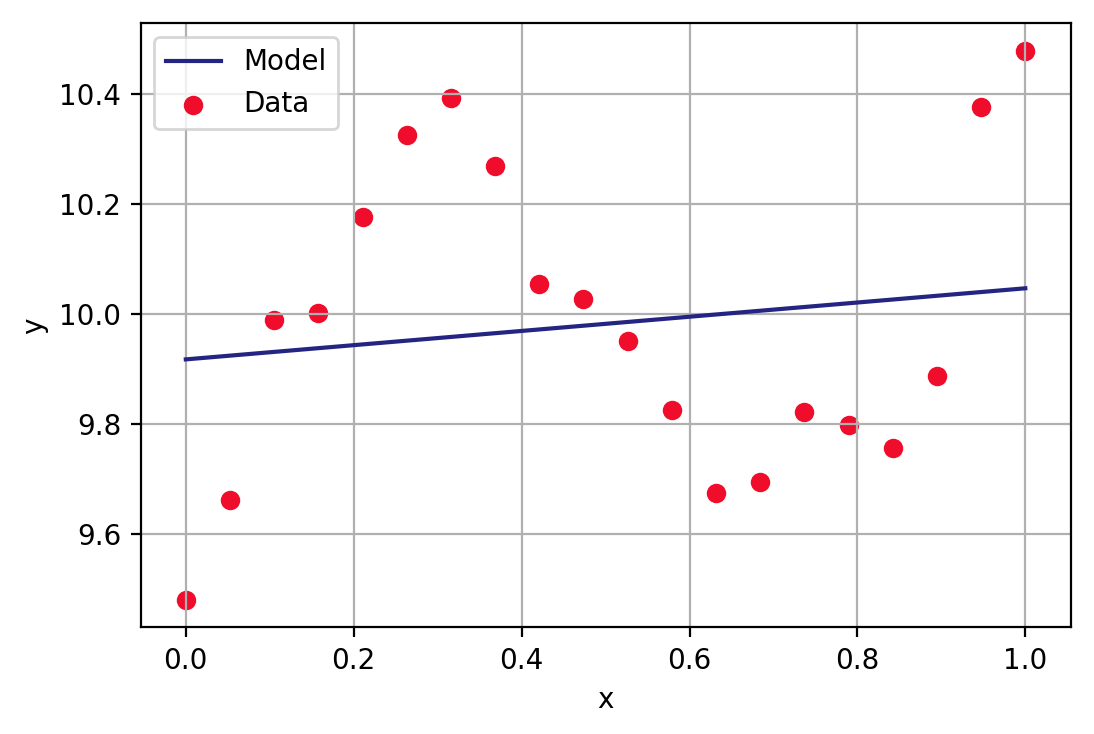

In [8]:
# Plot the predicted function at each of these points
x_plot = np.linspace(0, 1, 50)

# The degree of the polynomial
n = 1

# perform least squares then predict
y_plot = fit_poly(x_data, y_data, x_plot, n)

# plot the data
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(x_data, y_data)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Model', 'Data'])

It's not that great of a fit. Let's calculate some measure of fit, such as the mean squared error (MSE)

In [9]:
# Predict at the data points themselves
y_model = fit_poly(x_data, y_data, x_data, n)

# calculate MSE
MSE = np.mean((y_data - y_model)**2)

print("MSE (n = " + str(n) + ") = " + str(MSE))

MSE (n = 1) = 0.0730346343136588


Let's try other values of $n$.

MSE (n = 3) = 0.006801475800727851


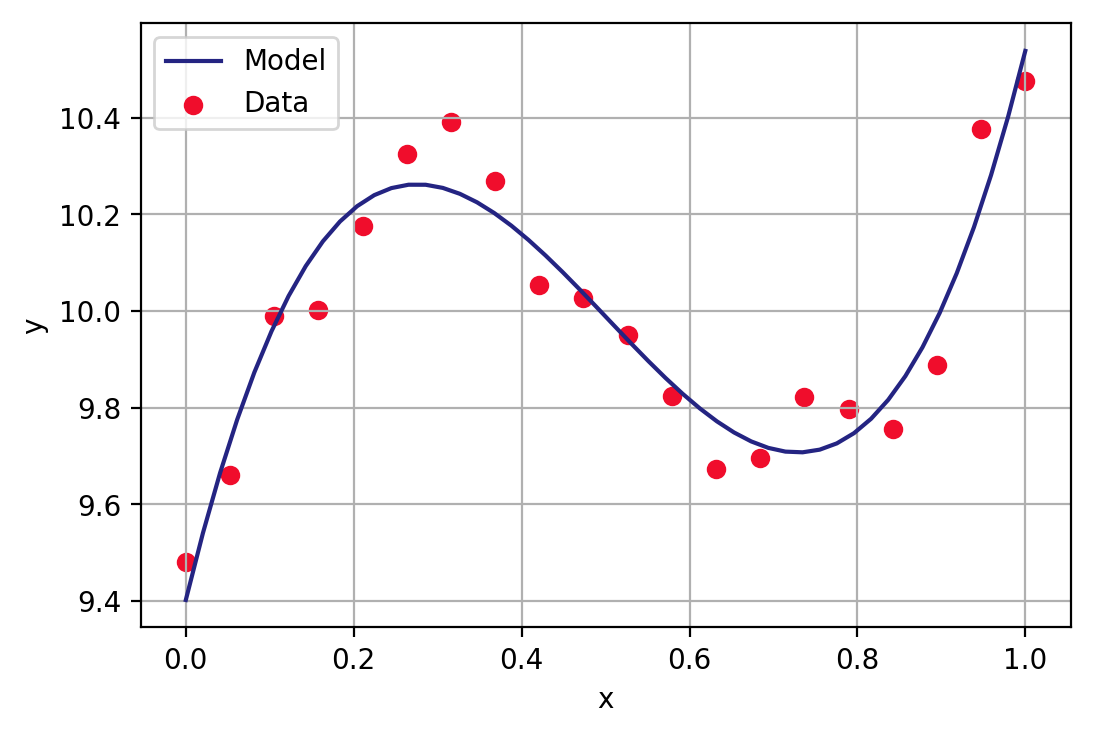

In [11]:
n = 3

# perform least squares then predict
y_plot = fit_poly(x_data, y_data, x_plot, n)

# plot the data
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(x_data, y_data)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Model', 'Data'])

# calculate MSE
y_model = fit_poly(x_data, y_data, x_data, n)
MSE = np.mean((y_data - y_model)**2)
print("MSE (n = " + str(n) + ") = " + str(MSE))

It's a very shallow parabola, as a result of trying to best fit the data. Try a few more by changing $n$ above.

Let's put this in a `for` loop, and calculate the MSE of the fit for various values of $n$.

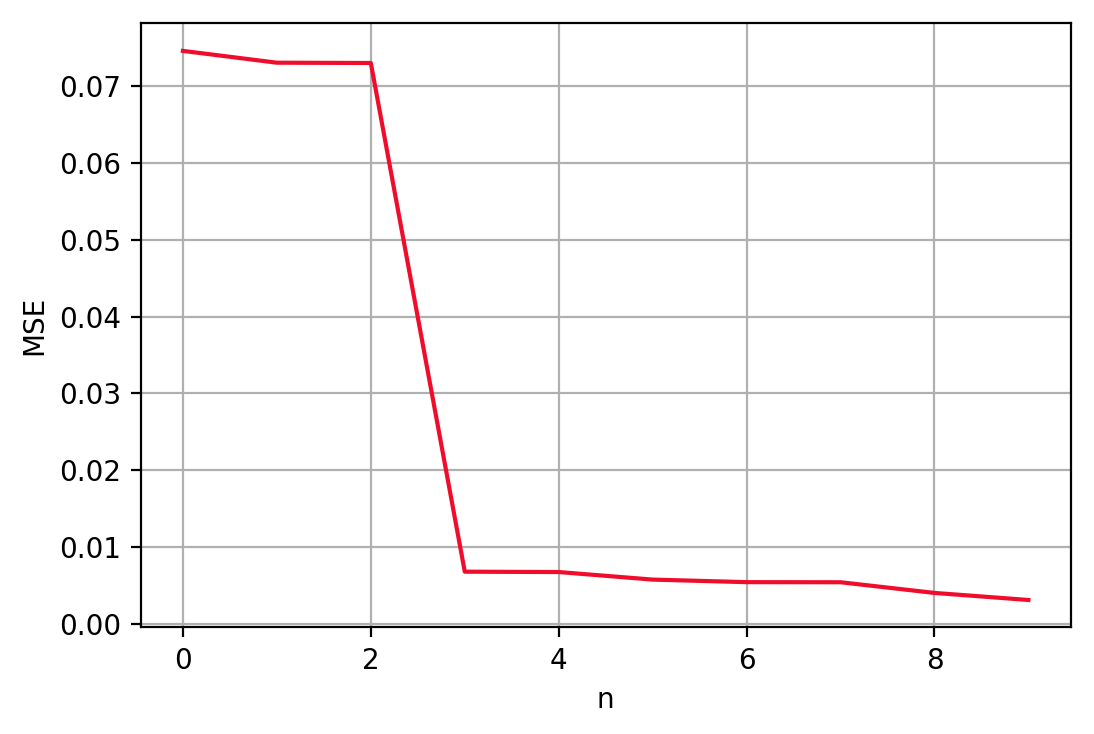

In [12]:
# Calculate the MSE for several model sizes
MSE_list = np.zeros(10)   
for n in range(10):
    # Train the model with n basis functions, predict the data
    y_model = fit_poly(x_data, y_data, x_data, n)
    # caculate the MSE
    MSE_list[n] = np.mean((y_data - y_model)**2)    
    
# Plot MSE vs. degree
plt.plot(MSE_list)
plt.xlabel('n')
plt.ylabel('MSE')
plt.grid()

It looks like MSE is minimized for large $n$. Does this mean we should take $n$ as large as possible? Let's look at the fit at $n = 20$.

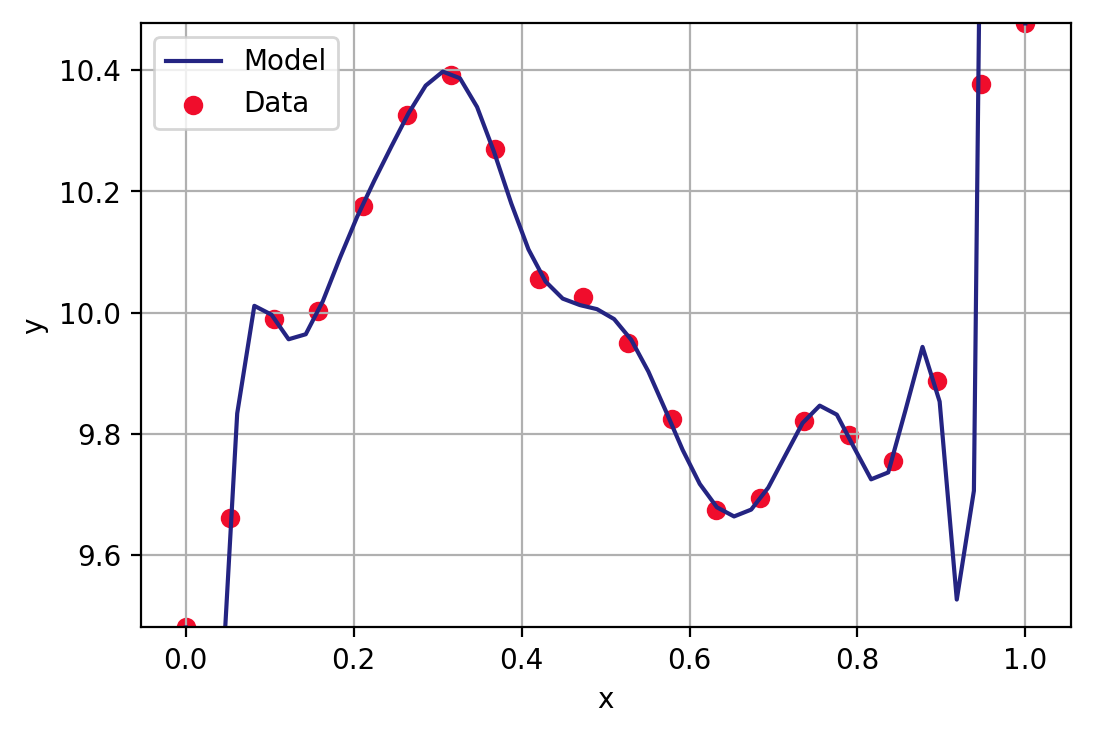

In [13]:
# perform least squares then predict
y_plot = fit_poly(x_data, y_data, x_plot, 20)

# plot the data
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(x_data, y_data)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([np.min(y_data), np.max(y_data)])
plt.legend(['Model', 'Data'])

This doesn't look right. In fact, this is a classical case of **overfitting**.

# Training, Validation and Testing Sets

How do we then pick the number of basis functions? (This number is called a **hyperparameter**). We'll pick it using a validation testing set. To do this, we'll need to break up our data into
* Training data set (about 80% of the data)
* Validation data set (about 80% of the remaining 20%)
* Testing data set (the rest).

These aren't set numbers, but generally rules of thumb. Below, for example, we'll split our 20 data points into sets of 12, 4 and 4 for the training, validation and testing sets, respectively.

In [14]:
num_data = len(data)
num_train = 12
num_valid = 4

# Since we're going to take contiguous subsets of data, it's best to shuffle 
# the data in case there was some inherent order in the data.
I_perm = np.random.permutation(num_data)
# rearrange the rows according to permutation
data = data[I_perm, :]

# rows 0-11 
training_set = data[0:num_train, :]
x_training = training_set[:, 0]
y_training = training_set[:, 1]

# rows 12-15
validation_set = data[num_train:(num_train + num_valid), :]
x_validation = validation_set[:, 0]
y_validation = validation_set[:, 1]

# rows 16 - 19
testing_set = data[(num_train + num_valid):, :]
x_testing = testing_set[:, 0]
y_testing = testing_set[:, 1]


In [15]:
N = 30
training_performance = np.zeros(N)
validation_performance = np.zeros(N)

# loop over each model
for n in range(N):
    # train model N (aka N basis elements) with training set
    y_model = fit_poly(x_training, y_training, x_training, n)
    training_performance[n] = np.mean((y_model - y_training)**2)
    
    # calculate performance with validation set
    y_model = fit_poly(x_training, y_training, x_validation, n)
    validation_performance[n] = np.mean((y_model - y_validation)**2)

Best model: n = 3


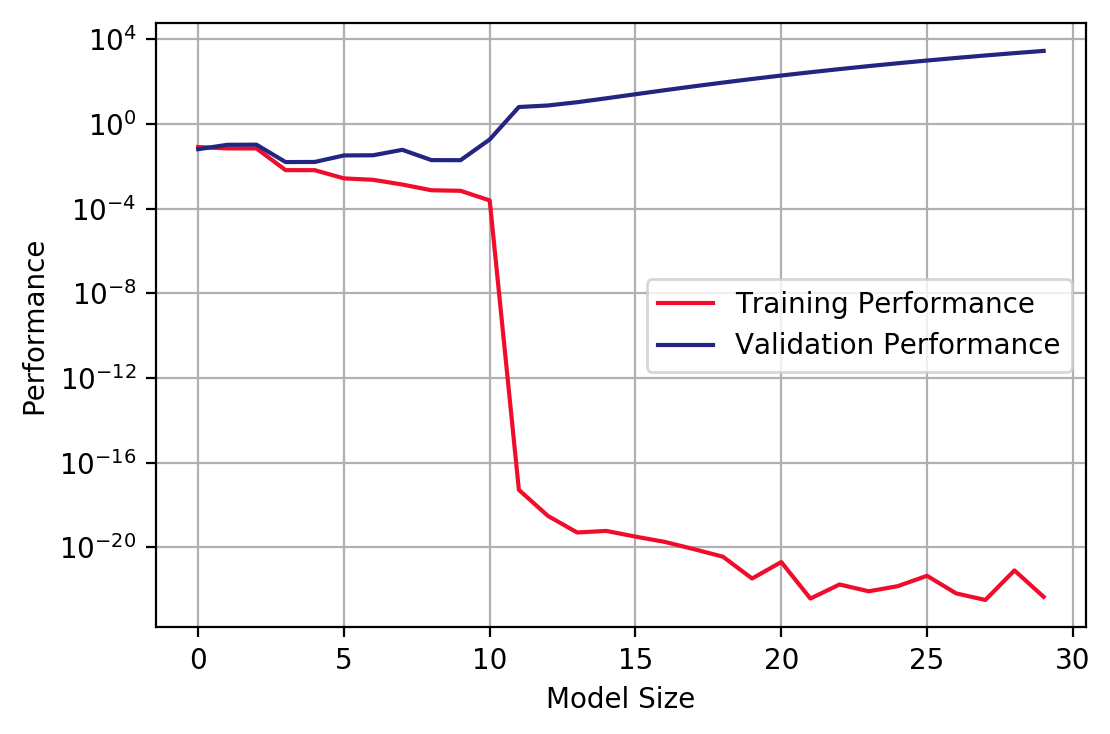

In [16]:
# Plot each model's performance
plt.figure()
plt.plot(training_performance)
plt.plot(validation_performance)
plt.xlabel('Model Size')
plt.ylabel('Performance')
plt.grid()
plt.legend(['Training Performance', 'Validation Performance'])
plt.yscale('log')

# Pick best performing model
n_best = np.argmin(validation_performance)
print("Best model: n = " + str(n_best))

In [17]:
# Now compare the final performance of the best model against testing set
y_model = fit_poly(x_training, y_training, x_testing, n_best)     
test_performance = np.mean((y_model - y_testing)**2)
print("MSE for testing set: " + str(test_performance))

MSE for testing set: 0.010465661895264445


Text(0, 0.5, '$y$')

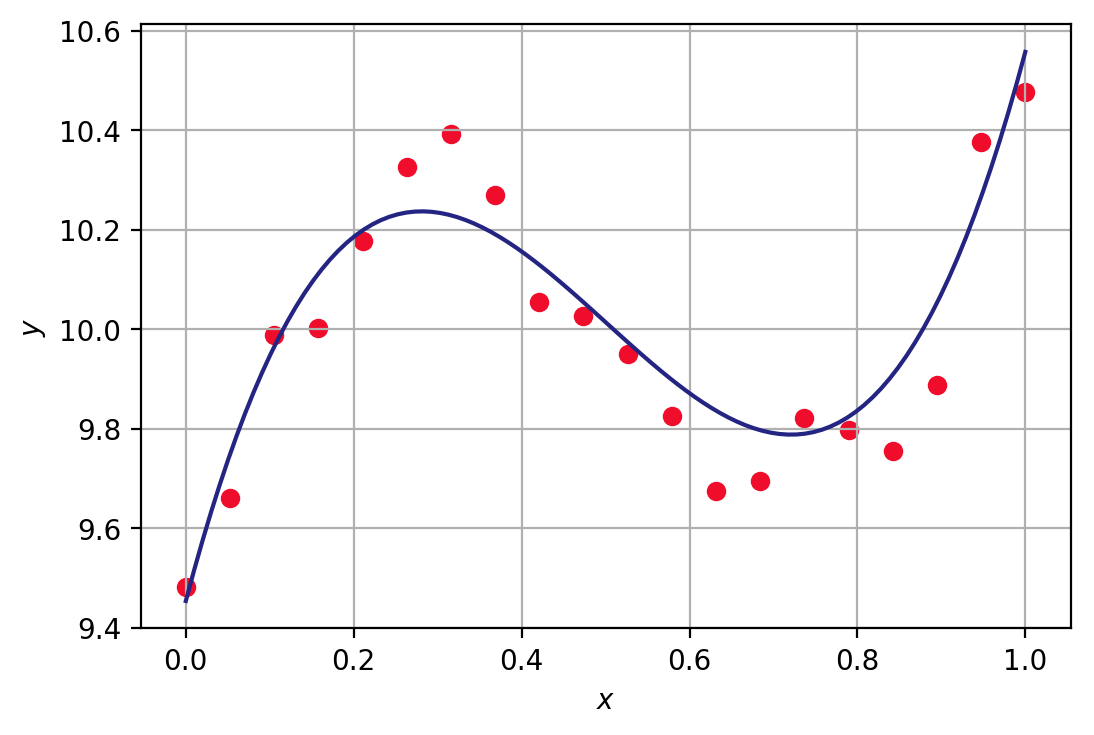

In [18]:
# Plot the best model, along with data sets
x_plot = np.linspace(0, 1, 100)
y_plot = y_model = fit_poly(x_training, y_training, x_plot, n_best)     

# Plot the two models, along with data
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(data[:,0], data[:,1])

plt.grid()
plt.xlabel('$x$')
plt.ylabel('$y$')

In [19]:
# k fold cross-validation
num_train = 16
print(num_train)

training_set = data[0:num_train, :]
x_training = training_set[:, 0]
y_training = training_set[:, 1]

testing_set = data[num_train:, :]
x_testing = testing_set[:, 0]
y_testing = testing_set[:, 1]

16


In [20]:
# Split the training data into 4 groups of 4
k = 4
num_per_group = int(num_train / k)

# loop over models
for n in range(N):

    # perform k validations and save performance for each validation    
    validation_performance_j = np.zeros(k)
    
    for j in range(k):
        
        # The boolean index to index the rows of training data that will be
        # treated as validation data for this round
        I = np.logical_and(j*num_per_group <= np.arange(num_train),
                           np.arange(num_train) < (j+1)*num_per_group)

        # Break up training data into this round's validation and training data
        validation_set_j = training_set[I, :]
        
        # the training data is everything not in validation set
        training_set_j = training_set[~I, :]
        
        # pick out input and output vectors from training set
        x_training_j = training_set_j[:, 0]
        y_training_j = training_set_j[:, 1]
        
        # pick out input and output vectors from validation set
        x_validation_j = validation_set_j[:, 0]
        y_validation_j = validation_set_j[:, 1]
        
        # train with training set
        y_model = fit_poly(x_training_j, y_training_j, x_validation_j, n)
        
        # save performance for the j-th validation set
        validation_performance_j[j] = np.mean((y_model -y_validation_j)**2)
    
        
    # Overall model performance for the i-th model is 
    # just the average over all validation sets
    validation_performance[n] = np.mean(validation_performance_j)
    
# At the end of this loop, model_performance will hold 
# the validation performance for each model

Best model: n = 3


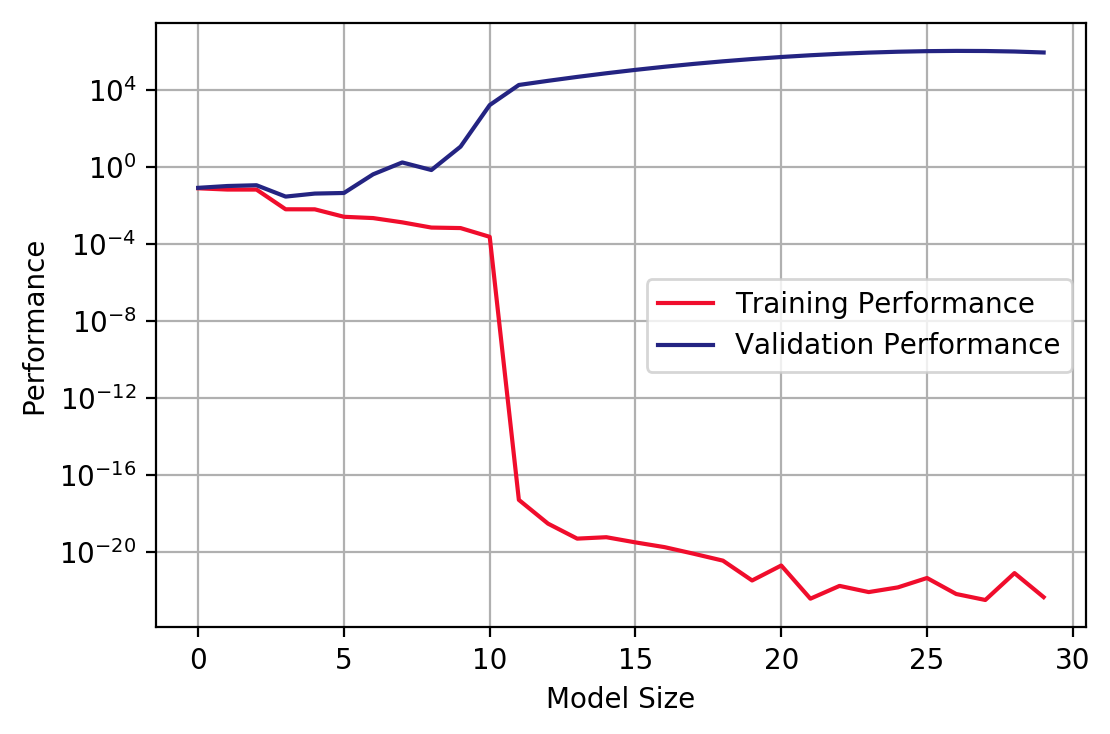

In [21]:
plt.plot(training_performance)
plt.plot(validation_performance)
plt.xlabel('Model Size')
plt.ylabel('Performance')
plt.grid()
plt.legend(['Training Performance', 'Validation Performance'])
plt.yscale('log')

# Pick best performing model
n_best = np.argmin(validation_performance)
print("Best model: n = " + str(n_best))

In [23]:
# Now compare the final performance of the best model against testing set
y_model = fit_poly(x_training, y_training, x_testing, n_best)     
test_performance = np.mean((y_model - y_testing)**2)
print("MSE for testing set: " + str(test_performance))

MSE for testing set: 0.005033248873038576


Text(0, 0.5, '$y$')

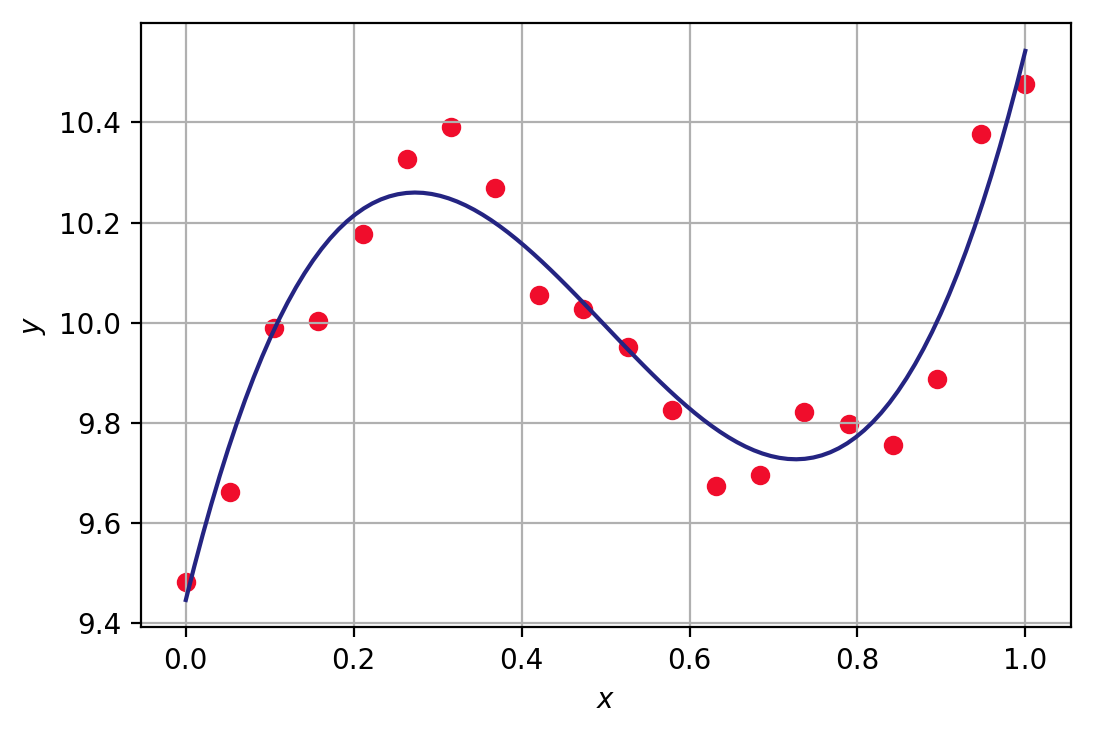

In [24]:
# Plot the best model, along with data sets
x_plot = np.linspace(0, 1, 100)
y_plot = y_model = fit_poly(x_training, y_training, x_plot, n_best)     

# Plot the two models, along with data
plt.plot(x_plot, y_plot, color = COLORS[1])
plt.scatter(data[:,0], data[:,1])

plt.grid()
plt.xlabel('$x$')
plt.ylabel('$y$')